## Descarga de datos históricos de Bancolombia ADR (CIB)

En esta celda se utiliza la librería `yfinance` para descargar el historial de precios de apertura del ADR de Bancolombia (símbolo "CIB") desde el 11 de mayo de 2015 hasta el 9 de mayo de 2025. Luego, se filtra únicamente la columna **Open** (precio de apertura) y se reinicia el índice para que la columna de fechas quede como una columna regular del DataFrame.


In [1]:
import yfinance as yf

# Descarga histórico de Bancolombia ADR (CIB)
df_principal = yf.download(
    "CIB", 
    start="2020-01-01", 
    end="2025-09-12"
)

# Filtrar solo la columna Open y mover el índice Date a columna
df_principal = df_principal[['Open']].reset_index()

print(df_principal.head())

C:\Users\Usuario\AppData\Local\Temp\ipykernel_4128\2298517273.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_principal = yf.download(
[*********************100%***********************]  1 of 1 completed

Price        Date       Open
Ticker                   CIB
0      2020-01-02  32.550085
1      2020-01-03  32.408206
2      2020-01-06  32.390467
3      2020-01-07  32.579657
4      2020-01-08  32.768833


[*********************100%***********************]  1 of 1 completed

Descargando CIB desde 2020-01-01 hasta 2025-09-12 ...
Datos descargados. Total registros: 1431
Train length: 1401, Test length: 30
Tipo de train: <class 'pandas.core.series.Series'> Tipo de test: <class 'pandas.core.series.Series'>
Naive           -> MAE: 4.606667, RMSE: 5.171759
Drift           -> MAE: 4.479241, RMSE: 5.026308
Ridge_AR        -> MAE: 5.383151, RMSE: 6.049933
Linear_AR       -> MAE: 5.418335, RMSE: 6.089993

Resumen ordenado por RMSE:
    model      MAE     RMSE
    Drift 4.479241 5.026308
    Naive 4.606667 5.171759
 Ridge_AR 5.383151 6.049933
Linear_AR 5.418335 6.089993


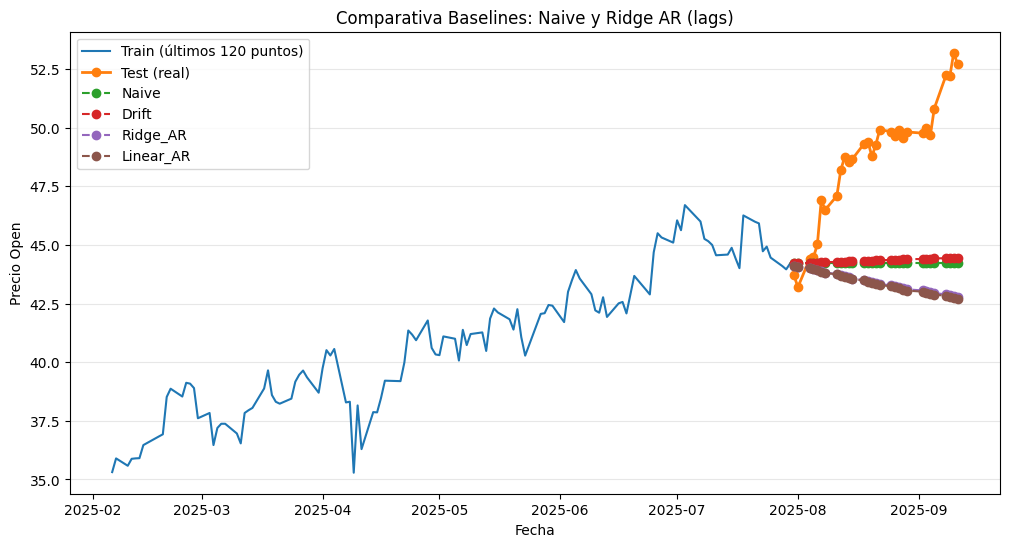

In [8]:
"""
Baselines para forecasting de precios (Open) de la acción CIB (Bancolombia ADR).
Baselines implementados:
 - Naive (último valor observado)
 - Regresión autoregresiva (RidgeCV) con lags + rolling means (predicción recursiva)

Correciones: manejo robusto de train/test si vienen como DataFrame; history construido desde valores.
"""

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# ---------- Helpers / métricas ----------
def _to_1d_series(x, name="y"):
    if isinstance(x, pd.Series):
        s = x.copy()
        s.name = name
        return s
    if isinstance(x, pd.DataFrame):
        if x.shape[1] == 1:
            s = x.iloc[:, 0].copy()
            s.name = name
            return s
        else:
            raise ValueError(f"DataFrame con más de 1 columna no es soportado (shape={x.shape})")
    arr = np.asarray(x)
    if arr.ndim == 2 and arr.shape[1] == 1:
        arr = arr.ravel()
    if arr.ndim > 2 or (arr.ndim == 2 and arr.shape[1] > 1):
        raise ValueError(f"Array de dimensiones no soportadas: shape={arr.shape}")
    return pd.Series(arr, name=name)

def _align_and_dropna(y_true, y_pred):
    s_true = _to_1d_series(y_true, name='y_true')
    s_pred = _to_1d_series(y_pred, name='y_pred')
    df = pd.concat([s_true, s_pred], axis=1, join='outer')
    df = df.dropna()
    return df['y_true'].values.astype(float), df['y_pred'].values.astype(float)

def mae(y_true, y_pred):
    yt, yp = _align_and_dropna(y_true, y_pred)
    if yt.size == 0:
        return np.nan
    return np.mean(np.abs(yt - yp))

def rmse(y_true, y_pred):
    yt, yp = _align_and_dropna(y_true, y_pred)
    if yt.size == 0:
        return np.nan
    return np.sqrt(np.mean((yt - yp)**2))


# ---------- 1) Descargar y preparar ----------
TICKER = "CIB"
START = "2020-01-01"
END = "2025-09-12"

print(f"Descargando {TICKER} desde {START} hasta {END} ...")
df_raw = yf.download(TICKER, start=START, end=END)
if df_raw is None or df_raw.empty:
    raise RuntimeError("No se descargaron datos. Revisa el ticker o la conexión a internet.")

# Usar la columna Open y asegurar índice datetime
if 'Open' not in df_raw.columns:
    raise RuntimeError("Columna 'Open' no encontrada en los datos descargados.")
df = df_raw[['Open']].reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
series = df['Open'].dropna()
print("Datos descargados. Total registros:", len(series))

# ---------- 2) Separar train/test ----------
N_test = 30
if len(series) <= N_test + 10:
    raise ValueError("Serie muy corta para el tamaño de test elegido. Reduce N_test.")
train = series.iloc[:-N_test].copy()
test = series.iloc[-N_test:].copy()
print(f"Train length: {len(train)}, Test length: {len(test)}")

# --- Robustecer: si por alguna razón train/test son DataFrames, convertir a Series (primera columna numérica)
def ensure_series(x, name='series'):
    if isinstance(x, pd.DataFrame):
        numeric_cols = x.select_dtypes(include=[np.number]).columns.tolist()
        if not numeric_cols:
            raise ValueError(f"{name} es DataFrame sin columnas numéricas.")
        s = x[numeric_cols[0]].copy()
        s.index = x.index
        return s
    elif isinstance(x, pd.Series):
        return x
    else:
        try:
            return pd.Series(x)
        except Exception as e:
            raise ValueError(f"No se pudo convertir {name} a pd.Series") from e

train = ensure_series(train, 'train')
test = ensure_series(test, 'test')

# debug tipos
print("Tipo de train:", type(train), "Tipo de test:", type(test))

# ---------- Baseline simple: Naive ----------
last_value = float(train.iloc[-1])
pred_naive = pd.Series([last_value] * len(test), index=test.index, name='Naive')


# ---------- Función robusta para crear features autoregresivos ----------
def make_lag_features(series_in, lags=(1,2,3,4,5), rolling_windows=(3,7)):
    """
    Crea DataFrame con columna 'y', lags 'lag_#', rolling means 'roll_#' y 'time_index'.
    Maneja series o dataframes, convierte a numérico, descarta NaNs iniciales.
    """
    # Si es DataFrame, tomar la primera columna numérica
    if isinstance(series_in, pd.DataFrame):
        if series_in.shape[1] == 1:
            s = series_in.iloc[:, 0].copy()
        else:
            numeric_cols = series_in.select_dtypes(include=[np.number]).columns.tolist()
            if not numeric_cols:
                raise ValueError("DataFrame no contiene columnas numéricas.")
            s = series_in[numeric_cols[0]].copy()
    elif isinstance(series_in, pd.Series):
        s = series_in.copy()
    else:
        try:
            s = pd.Series(series_in)
        except Exception as e:
            raise ValueError("No se pudo convertir la entrada a pd.Series") from e

    # Convertir a numérico (no convertibles -> NaN)
    s = pd.to_numeric(s, errors='coerce')

    # Eliminar NaNs en la serie original (si hay)
    if s.isna().any():
        nna = s.isna().sum()
        print(f"Nota: la serie contiene {nna} NaNs. Serán eliminados antes de crear lags.")
        s = s.dropna()
        if s.empty:
            raise ValueError("La serie quedó vacía tras eliminar NaNs.")

    s = s.astype(float)
    s.name = 'y'
    df_feat = pd.DataFrame({'y': s})

    # Lags
    for l in lags:
        df_feat[f'lag_{l}'] = df_feat['y'].shift(l)

    # Rolling means de valores pasados (shift(1) para que no use el valor actual)
    for w in rolling_windows:
        df_feat[f'roll_{w}'] = df_feat['y'].shift(1).rolling(window=w, min_periods=1).mean()

    # Time index (posición)
    df_feat['time_index'] = np.arange(len(df_feat))

    return df_feat

# ---------- 4) Baseline mejorado: Regresión autoregresiva (RidgeCV) ----------
LAGS = [1,2,3,4,5]
ROLLS = [3,7]

df_feat = make_lag_features(series, lags=LAGS, rolling_windows=ROLLS)

# Asegurar intersección de índices con train (por si se eliminaron NaNs)
idx_train_inter = df_feat.index.intersection(train.index)
if len(idx_train_inter) == 0:
    raise ValueError("No hay intersección entre los índices de df_feat y train. Revisa NaNs o índices.")

df_train = df_feat.loc[idx_train_inter].dropna().copy()
if df_train.shape[0] == 0:
    raise ValueError("df_train quedó vacío después de dropna(). Reduce lags/rolling o verifica NaNs.")

X_train = df_train[[f'lag_{l}' for l in LAGS] + [f'roll_{w}' for w in ROLLS] + ['time_index']].values
y_train = df_train['y'].values

# Escalado y modelo
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

alphas = np.logspace(-3, 3, 21)
model_ridge = RidgeCV(alphas=alphas, store_cv_values=False)
model_ridge.fit(X_train_scaled, y_train)

# Predicción recursiva (horizonte N_test)
# --- Construir history desde valores (no usar .tolist() directamente sobre DataFrame)
history = list(train.values.astype(float))
preds_ridge = []

for step in range(len(test)):
    feat = []
    last_idx = len(history) - 1

    # lags (lag_1 = history[-1], lag_2 = history[-2], ...)
    for l in LAGS:
        pos = last_idx - (l - 1)
        feat.append(history[pos] if pos >= 0 else np.nan)

    # rolling means
    for w in ROLLS:
        if w <= len(history):
            feat.append(np.mean(history[-w:]))
        else:
            feat.append(np.mean(history))

    # time_index: aproximado (tomamos la posición en df_feat)
    feat.append(len(df_feat) - len(test) + len(preds_ridge))

    feat = np.array(feat, dtype=float)

    # rellenar NaNs con medias de las columnas de X_train (fallback)
    if np.isnan(feat).any():
        col_means = np.nanmean(X_train, axis=0)
        nanmask = np.isnan(feat)
        feat[nanmask] = col_means[nanmask]

    feat_scaled = scaler.transform(feat.reshape(1, -1))
    yhat = model_ridge.predict(feat_scaled)[0]
    preds_ridge.append(float(yhat))
    history.append(float(yhat))

pred_ridge_ar = pd.Series(preds_ridge, index=test.index, name='Ridge_AR')


# ---------- Baseline: Drift Forecast ----------
# Fórmula: y_t + h * (y_t - y_1) / (t - 1)
y_t = float(train.iloc[-1])
y_1 = float(train.iloc[0])
t = len(train)

drift_slope = (y_t - y_1) / (t - 1)
pred_drift = pd.Series(
    [y_t + (i + 1) * drift_slope for i in range(len(test))],
    index=test.index,
    name='Drift'
)



from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)
# Predicción recursiva con modelo de regresión lineal
history_lr = list(train.values.astype(float))
preds_lr = []

for step in range(len(test)):
    feat = []
    last_idx = len(history_lr) - 1

    # lags
    for l in LAGS:
        pos = last_idx - (l - 1)
        feat.append(history_lr[pos] if pos >= 0 else np.nan)

    # rolling
    for w in ROLLS:
        if w <= len(history_lr):
            feat.append(np.mean(history_lr[-w:]))
        else:
            feat.append(np.mean(history_lr))

    # time index
    feat.append(len(df_feat) - len(test) + len(preds_lr))

    feat = np.array(feat, dtype=float)

    # rellenar NaNs con medias
    if np.isnan(feat).any():
        col_means = np.nanmean(X_train, axis=0)
        feat[np.isnan(feat)] = col_means[np.isnan(feat)]

    feat_scaled = scaler.transform(feat.reshape(1, -1))
    yhat = model_lr.predict(feat_scaled)[0]
    preds_lr.append(float(yhat))
    history_lr.append(float(yhat))

pred_lr_ar = pd.Series(preds_lr, index=test.index, name='LinearRegression_AR')



# ---------- 5) Calcular métricas y mostrar resultados ----------
models = {
    'Naive': pred_naive,
    'Drift': pred_drift,
    'Ridge_AR': pred_ridge_ar,
    'Linear_AR': pred_lr_ar
}

results = []
for name, pred in models.items():
    m_mae = mae(test, pred)
    m_rmse = rmse(test, pred)
    results.append((name, m_mae, m_rmse))
    print(f"{name:15s} -> MAE: {m_mae:.6f}, RMSE: {m_rmse:.6f}")

res_df = pd.DataFrame(results, columns=['model', 'MAE', 'RMSE']).sort_values('RMSE')
print("\nResumen ordenado por RMSE:")
print(res_df.to_string(index=False))

# ---------- 6) Visualización ----------
plt.figure(figsize=(12,6))
if len(train) > 120:
    plt.plot(train[-120:], label='Train (últimos 120 puntos)')
else:
    plt.plot(train, label='Train')
plt.plot(test, marker='o', linestyle='-', label='Test (real)', linewidth=2)

for name, pred in models.items():
    plt.plot(pred, marker='o', linestyle='--', label=name)

plt.legend()
plt.title("Comparativa Baselines: Naive y Ridge AR (lags)")
plt.xlabel("Fecha")
plt.ylabel("Precio Open")
plt.grid(axis='y', alpha=0.3)
plt.show()

# ---------- Fin ----------


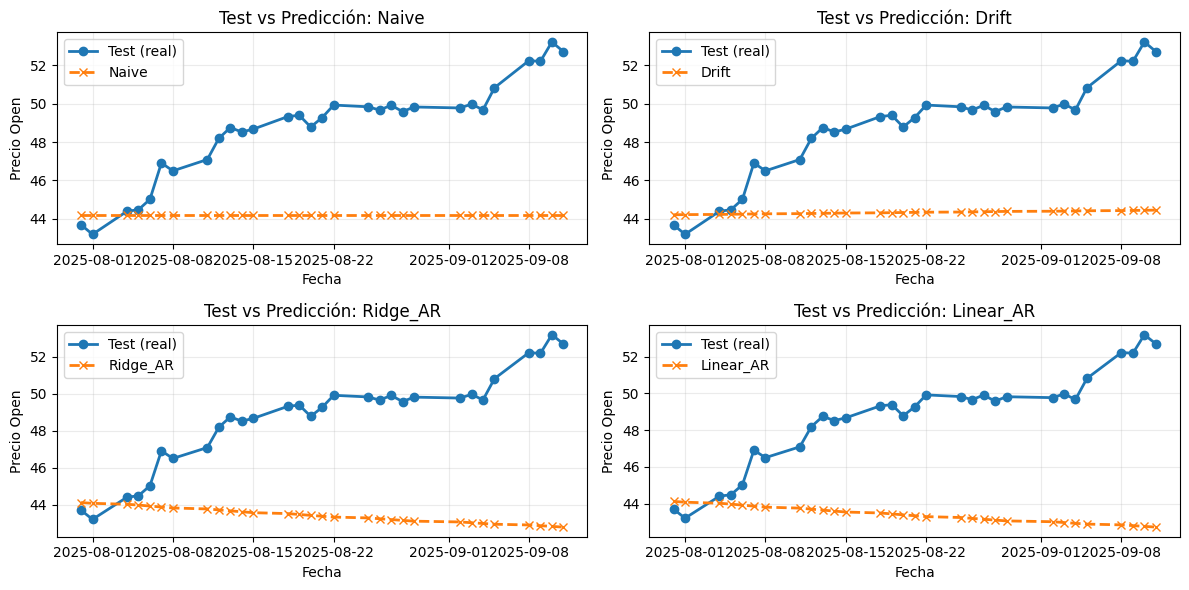

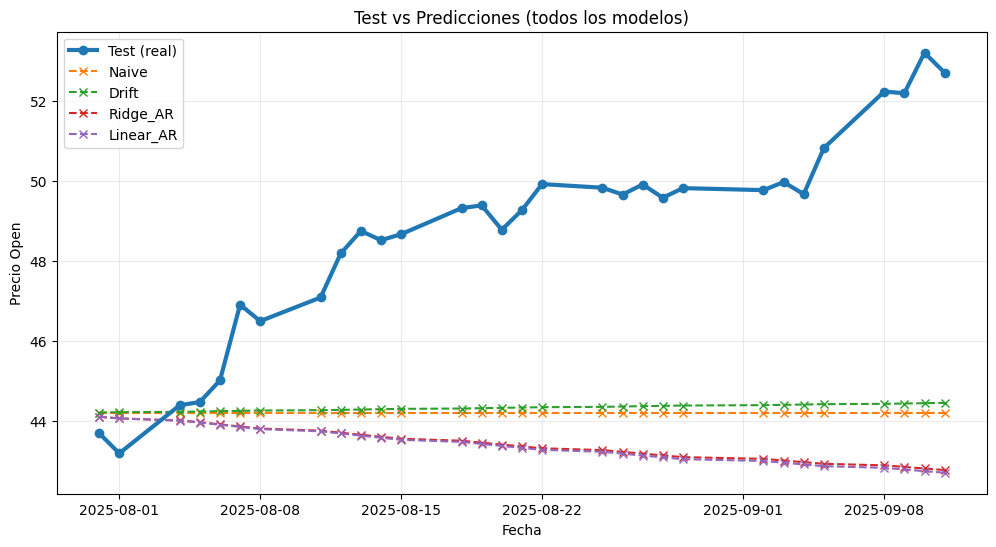

In [ ]:
import math
import matplotlib.pyplot as plt

# Opción A: Un subplot por modelo (uno arriba de otro o en cuadrícula)
def plot_each_model_separately(models_dict=models, test_series=test, max_cols=2, figsize_per_plot=(6,3)):
    model_names = list(models_dict.keys())
    n = len(model_names)
    cols = min(max_cols, n)
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(figsize_per_plot[0]*cols, figsize_per_plot[1]*rows), squeeze=False)
    for idx, name in enumerate(model_names):
        r = idx // cols
        c = idx % cols
        ax = axes[r][c]
        ax.plot(test_series, marker='o', linestyle='-', label='Test (real)', linewidth=2)
        ax.plot(models_dict[name], marker='x', linestyle='--', label=name, linewidth=2)
        ax.set_title(f"Test vs Predicción: {name}")
        ax.set_xlabel("Fecha")
        ax.set_ylabel("Precio Open")
        ax.legend()
        ax.grid(alpha=0.25)
    # ocultar ejes vacíos
    total_plots = rows * cols
    for empty_idx in range(n, total_plots):
        r = empty_idx // cols
        c = empty_idx % cols
        axes[r][c].axis('off')
    plt.tight_layout()
    plt.show()

# Opción B: Todos los modelos en la misma figura (overlay)
def plot_all_models_overlay(models_dict=models, test_series=test, figsize=(12,6)):
    plt.figure(figsize=figsize)
    plt.plot(test_series, marker='o', linestyle='-', label='Test (real)', linewidth=3, zorder=10)
    for name, pred in models_dict.items():
        plt.plot(pred, marker='x', linestyle='--', label=name, linewidth=1.5)
    plt.title("Test vs Predicciones (todos los modelos)")
    plt.xlabel("Fecha")
    plt.ylabel("Precio Open")
    plt.legend()
    plt.grid(alpha=0.25)
    plt.show()

# Ejecución de ejemplo:
plot_each_model_separately()    # genera un subplot por modelo
plot_all_models_overlay()       # genera la figura con todos superpuestos

## media movil

[*********************100%***********************]  1 of 1 completed

Descargando CIB desde 2020-01-01 hasta 2025-09-12 ...
Datos descargados. Total registros: 1431
Train length: 1401, Test length: 30
Tipo de train: <class 'pandas.core.series.Series'> Tipo de test: <class 'pandas.core.series.Series'>
Naive           -> MAE: 4.606667, RMSE: 5.171759
Drift           -> MAE: 4.446212, RMSE: 4.988629
SMA_2           -> MAE: 4.678427, RMSE: 5.244535
Ridge_AR        -> MAE: 5.027183, RMSE: 5.648108
Linear_AR       -> MAE: 5.034195, RMSE: 5.657166

Resumen ordenado por RMSE:
    model      MAE     RMSE
    Drift 4.446212 4.988629
    Naive 4.606667 5.171759
    SMA_2 4.678427 5.244535
 Ridge_AR 5.027183 5.648108
Linear_AR 5.034195 5.657166


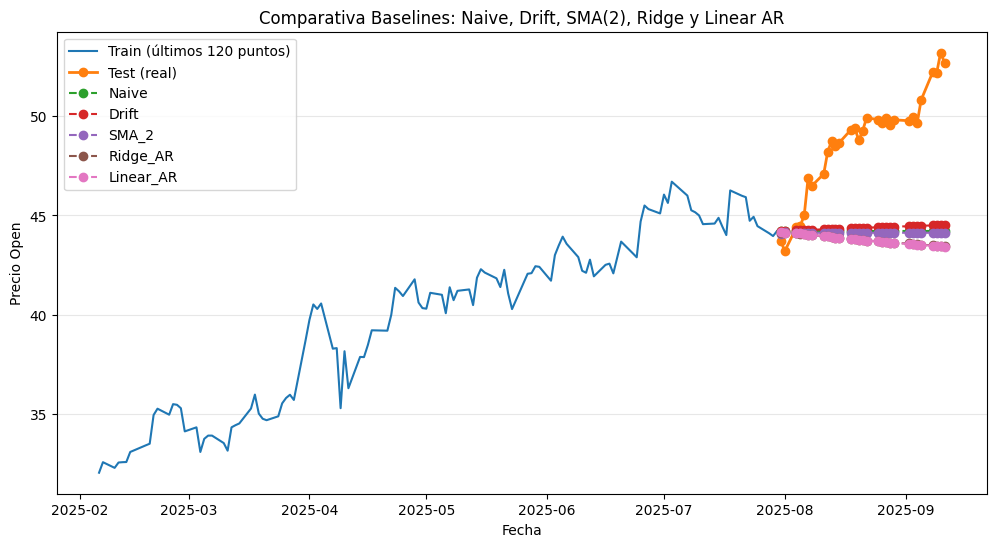

In [11]:
# Baselines forecasting CIB (Bancolombia ADR) - script completo con SMA
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Métricas y helpers
def _to_1d_series(x, name="y"):
    if isinstance(x, pd.Series):
        s = x.copy(); s.name = name; return s
    if isinstance(x, pd.DataFrame):
        if x.shape[1] == 1:
            s = x.iloc[:, 0].copy(); s.name = name; return s
        else:
            raise ValueError(f"DataFrame con más de 1 columna no es soportado (shape={x.shape})")
    arr = np.asarray(x)
    if arr.ndim == 2 and arr.shape[1] == 1:
        arr = arr.ravel()
    if arr.ndim > 2 or (arr.ndim == 2 and arr.shape[1] > 1):
        raise ValueError(f"Array de dimensiones no soportadas: shape={arr.shape}")
    return pd.Series(arr, name=name)

def _align_and_dropna(y_true, y_pred):
    s_true = _to_1d_series(y_true, name='y_true')
    s_pred = _to_1d_series(y_pred, name='y_pred')
    df = pd.concat([s_true, s_pred], axis=1, join='outer')
    df = df.dropna()
    return df['y_true'].values.astype(float), df['y_pred'].values.astype(float)

def mae(y_true, y_pred):
    yt, yp = _align_and_dropna(y_true, y_pred)
    if yt.size == 0:
        return np.nan
    return np.mean(np.abs(yt - yp))

def rmse(y_true, y_pred):
    yt, yp = _align_and_dropna(y_true, y_pred)
    if yt.size == 0:
        return np.nan
    return np.sqrt(np.mean((yt - yp)**2))

# ---------- 1) Descargar y preparar ----------
TICKER = "CIB"
START = "2020-01-01"
END = "2025-09-12"

print(f"Descargando {TICKER} desde {START} hasta {END} ...")
df_raw = yf.download(TICKER, start=START, end=END)
if df_raw is None or df_raw.empty:
    raise RuntimeError("No se descargaron datos. Revisa el ticker o la conexión a internet.")

if 'Open' not in df_raw.columns:
    raise RuntimeError("Columna 'Open' no encontrada en los datos descargados.")
df = df_raw[['Open']].reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
series = df['Open'].dropna()
print("Datos descargados. Total registros:", len(series))

# ---------- 2) Separar train/test ----------
N_test = 30
if len(series) <= N_test + 10:
    raise ValueError("Serie muy corta para el tamaño de test elegido. Reduce N_test.")
train = series.iloc[:-N_test].copy()
test = series.iloc[-N_test:].copy()
print(f"Train length: {len(train)}, Test length: {len(test)}")

# Robustecer: convertir DataFrame->Series si hace falta
def ensure_series(x, name='series'):
    if isinstance(x, pd.DataFrame):
        numeric_cols = x.select_dtypes(include=[np.number]).columns.tolist()
        if not numeric_cols:
            raise ValueError(f"{name} es DataFrame sin columnas numéricas.")
        s = x[numeric_cols[0]].copy()
        s.index = x.index
        return s
    elif isinstance(x, pd.Series):
        return x
    else:
        try:
            return pd.Series(x)
        except Exception as e:
            raise ValueError(f"No se pudo convertir {name} a pd.Series") from e

train = ensure_series(train, 'train')
test = ensure_series(test, 'test')

print("Tipo de train:", type(train), "Tipo de test:", type(test))

# ---------- Helpers para features ----------
def make_lag_features(series_in, lags=(1,2,3,4,5), rolling_windows=(3,7)):
    # convertir a pd.Series numérica
    if isinstance(series_in, pd.DataFrame):
        if series_in.shape[1] == 1:
            s = series_in.iloc[:, 0].copy()
        else:
            numeric_cols = series_in.select_dtypes(include=[np.number]).columns.tolist()
            if not numeric_cols:
                raise ValueError("DataFrame no contiene columnas numéricas.")
            s = series_in[numeric_cols[0]].copy()
    elif isinstance(series_in, pd.Series):
        s = series_in.copy()
    else:
        try:
            s = pd.Series(series_in)
        except Exception as e:
            raise ValueError("No se pudo convertir la entrada a pd.Series") from e

    s = pd.to_numeric(s, errors='coerce')
    if s.isna().any():
        nna = s.isna().sum()
        print(f"Nota: la serie contiene {nna} NaNs. Serán eliminados antes de crear lags.")
        s = s.dropna()
        if s.empty:
            raise ValueError("La serie quedó vacía tras eliminar NaNs.")
    s = s.astype(float)
    s.name = 'y'
    df_feat = pd.DataFrame({'y': s})

    for l in lags:
        df_feat[f'lag_{l}'] = df_feat['y'].shift(l)
    for w in rolling_windows:
        df_feat[f'roll_{w}'] = df_feat['y'].shift(1).rolling(window=w, min_periods=1).mean()

    df_feat['time_index'] = np.arange(len(df_feat))
    return df_feat

# ---------- 4) Baseline autoregresivo (RidgeCV) ----------
LAGS = [1,2,3,4,5]
ROLLS = [3,7]

df_feat = make_lag_features(series, lags=LAGS, rolling_windows=ROLLS)

idx_train_inter = df_feat.index.intersection(train.index)
if len(idx_train_inter) == 0:
    raise ValueError("No hay intersección entre los índices de df_feat y train. Revisa NaNs o índices.")

df_train = df_feat.loc[idx_train_inter].dropna().copy()
if df_train.shape[0] == 0:
    raise ValueError("df_train quedó vacío después de dropna(). Reduce lags/rolling o verifica NaNs.")

X_train = df_train[[f'lag_{l}' for l in LAGS] + [f'roll_{w}' for w in ROLLS] + ['time_index']].values
y_train = df_train['y'].values

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

alphas = np.logspace(-3, 3, 21)
model_ridge = RidgeCV(alphas=alphas, store_cv_values=False)
model_ridge.fit(X_train_scaled, y_train)

# Predicción recursiva Ridge
history = list(train.values.astype(float))
preds_ridge = []

for step in range(len(test)):
    feat = []
    last_idx = len(history) - 1
    for l in LAGS:
        pos = last_idx - (l - 1)
        feat.append(history[pos] if pos >= 0 else np.nan)
    for w in ROLLS:
        if w <= len(history):
            feat.append(np.mean(history[-w:]))
        else:
            feat.append(np.mean(history))
    feat.append(len(df_feat) - len(test) + len(preds_ridge))
    feat = np.array(feat, dtype=float)
    if np.isnan(feat).any():
        col_means = np.nanmean(X_train, axis=0)
        feat[np.isnan(feat)] = col_means[np.isnan(feat)]
    feat_scaled = scaler.transform(feat.reshape(1, -1))
    yhat = model_ridge.predict(feat_scaled)[0]
    preds_ridge.append(float(yhat))
    history.append(float(yhat))

pred_ridge_ar = pd.Series(preds_ridge, index=test.index, name='Ridge_AR')

# ---------- Baseline simple: Naive ----------
last_value = float(train.iloc[-1])
pred_naive = pd.Series([last_value] * len(test), index=test.index, name='Naive')

# ---------- Baseline: Drift Forecast ----------
y_t = float(train.iloc[-1])
y_1 = float(train.iloc[0])
t = len(train)

drift_slope = (y_t - y_1) / (t - 1)
pred_drift = pd.Series(
    [y_t + (i + 1) * drift_slope for i in range(len(test))],
    index=test.index,
    name='Drift'
)


# ---------- Baseline adicional: SMA(2) recursivo ----------
# Predicción de t+1 = promedio de los dos últimos valores (t y t-1)
WINDOW = 2

history_sma = list(train.values.astype(float))
preds_sma = []

for step in range(len(test)):
    if len(history_sma) >= WINDOW:
        yhat = float(np.mean(history_sma[-WINDOW:]))
    else:
        yhat = float(np.mean(history_sma))
    preds_sma.append(yhat)
    history_sma.append(yhat)

pred_sma2 = pd.Series(preds_sma, index=test.index, name='SMA_2')


# ---------- Baseline adicional: Regresión lineal autoregresiva ----------
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)

history_lr = list(train.values.astype(float))
preds_lr = []

for step in range(len(test)):
    feat = []
    last_idx = len(history_lr) - 1

    # lags
    for l in LAGS:
        pos = last_idx - (l - 1)
        feat.append(history_lr[pos] if pos >= 0 else np.nan)

    # rolling
    for w in ROLLS:
        if w <= len(history_lr):
            feat.append(np.mean(history_lr[-w:]))
        else:
            feat.append(np.mean(history_lr))

    # time index
    feat.append(len(df_feat) - len(test) + len(preds_lr))

    feat = np.array(feat, dtype=float)

    if np.isnan(feat).any():
        col_means = np.nanmean(X_train, axis=0)
        feat[np.isnan(feat)] = col_means[np.isnan(feat)]

    feat_scaled = scaler.transform(feat.reshape(1, -1))
    yhat = model_lr.predict(feat_scaled)[0]
    preds_lr.append(float(yhat))
    history_lr.append(float(yhat))

pred_lr_ar = pd.Series(preds_lr, index=test.index, name='LinearRegression_AR')


# ---------- 5) Calcular métricas y mostrar resultados ----------
models = {
    'Naive': pred_naive,
    'Drift': pred_drift,
    'SMA_2': pred_sma2,
    'Ridge_AR': pred_ridge_ar,
    'Linear_AR': pred_lr_ar
}

results = []
for name, pred in models.items():
    m_mae = mae(test, pred)
    m_rmse = rmse(test, pred)
    results.append((name, m_mae, m_rmse))
    print(f"{name:15s} -> MAE: {m_mae:.6f}, RMSE: {m_rmse:.6f}")

res_df = pd.DataFrame(results, columns=['model', 'MAE', 'RMSE']).sort_values('RMSE')
print("\nResumen ordenado por RMSE:")
print(res_df.to_string(index=False))


# ---------- 6) Visualización ----------
plt.figure(figsize=(12,6))
if len(train) > 120:
    plt.plot(train[-120:], label='Train (últimos 120 puntos)')
else:
    plt.plot(train, label='Train')

plt.plot(test, marker='o', linestyle='-', label='Test (real)', linewidth=2)

for name, pred in models.items():
    plt.plot(pred, marker='o', linestyle='--', label=name)

plt.legend()
plt.title(f"Comparativa Baselines: Naive, Drift, SMA(2), Ridge y Linear AR")
plt.xlabel("Fecha")
plt.ylabel("Precio Open")
plt.grid(axis='y', alpha=0.3)
plt.show()


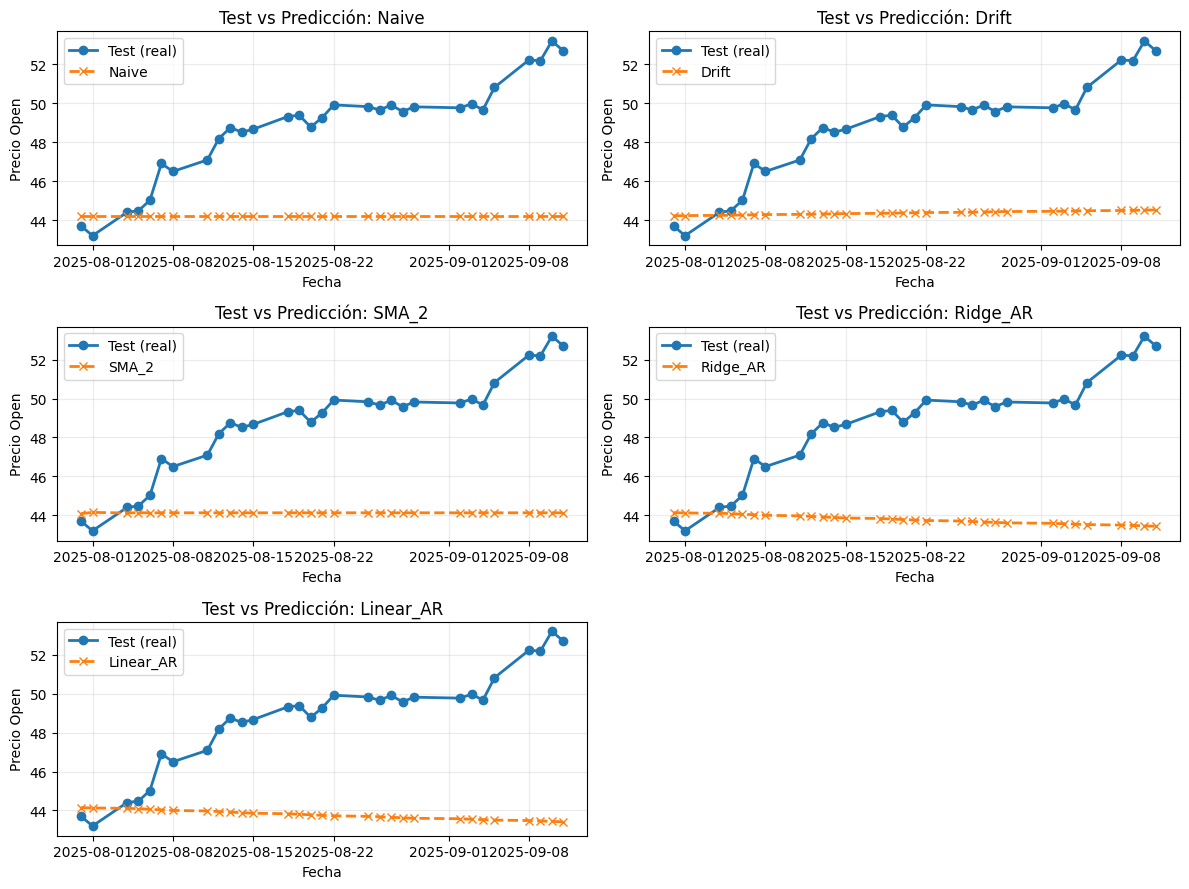

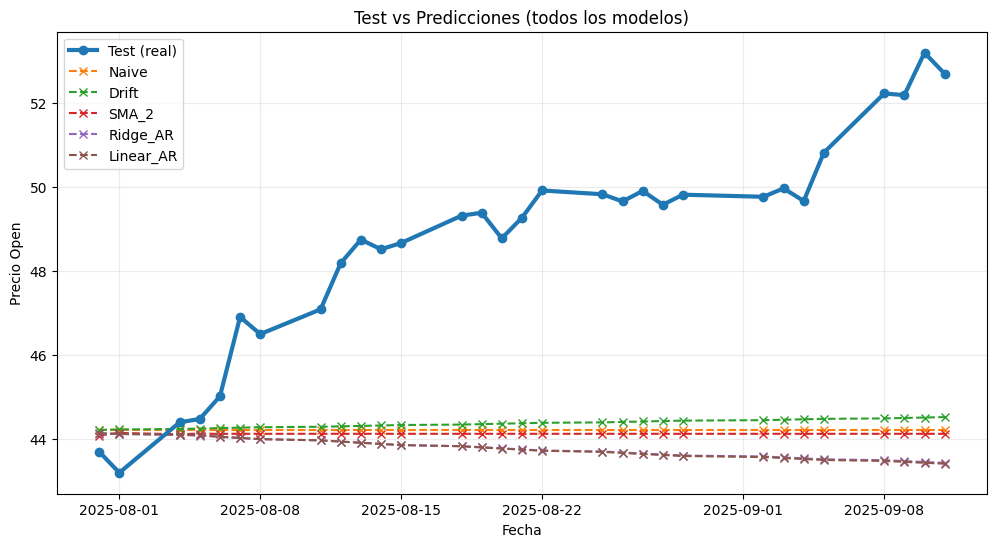

In [12]:
import math
import matplotlib.pyplot as plt

# Opción A: Un subplot por modelo (uno arriba de otro o en cuadrícula)
def plot_each_model_separately(models_dict=models, test_series=test, max_cols=2, figsize_per_plot=(6,3)):
    model_names = list(models_dict.keys())
    n = len(model_names)
    cols = min(max_cols, n)
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(figsize_per_plot[0]*cols, figsize_per_plot[1]*rows), squeeze=False)
    for idx, name in enumerate(model_names):
        r = idx // cols
        c = idx % cols
        ax = axes[r][c]
        ax.plot(test_series, marker='o', linestyle='-', label='Test (real)', linewidth=2)
        ax.plot(models_dict[name], marker='x', linestyle='--', label=name, linewidth=2)
        ax.set_title(f"Test vs Predicción: {name}")
        ax.set_xlabel("Fecha")
        ax.set_ylabel("Precio Open")
        ax.legend()
        ax.grid(alpha=0.25)
    # ocultar ejes vacíos
    total_plots = rows * cols
    for empty_idx in range(n, total_plots):
        r = empty_idx // cols
        c = empty_idx % cols
        axes[r][c].axis('off')
    plt.tight_layout()
    plt.show()

# Opción B: Todos los modelos en la misma figura (overlay)
def plot_all_models_overlay(models_dict=models, test_series=test, figsize=(12,6)):
    plt.figure(figsize=figsize)
    plt.plot(test_series, marker='o', linestyle='-', label='Test (real)', linewidth=3, zorder=10)
    for name, pred in models_dict.items():
        plt.plot(pred, marker='x', linestyle='--', label=name, linewidth=1.5)
    plt.title("Test vs Predicciones (todos los modelos)")
    plt.xlabel("Fecha")
    plt.ylabel("Precio Open")
    plt.legend()
    plt.grid(alpha=0.25)
    plt.show()

# Ejecución de ejemplo:
plot_each_model_separately()    # genera un subplot por modelo
plot_all_models_overlay()       # genera la figura con todos superpuestos

## media movil

[*********************100%***********************]  1 of 1 completed

Descargando CIB desde 2020-01-01 hasta 2025-09-12 ...

--- DIAGNÓSTICO inicial de df_raw ---
type(df_raw) = <class 'pandas.core.frame.DataFrame'>
repr(df_raw.head(3)):
Price           Close       High        Low       Open  Volume
Ticker            CIB        CIB        CIB        CIB     CIB
Date                                                          
2020-01-02  29.613585  29.736930  29.254273  29.527779  125300
2020-01-03  29.495611  29.592142  28.937876  29.399080  809300
2020-01-06  29.613585  29.785195  29.340079  29.382982  386800
----------------------------------------
Intento convertir df_raw -> serie 1-D. Resultado info:
{'case': 'pd.DataFrame',
 'extracted_col': ('Close', 'CIB'),
 'original_type': <class 'pandas.core.frame.DataFrame'>,
 'shape': (1431, 5)}
----------------------------------------
type(s_raw): <class 'pandas.core.series.Series'>
s_raw.head(5):
Date
2020-01-02    29.613585
2020-01-03    29.495611
2020-01-06    29.613585
2020-01-07    29.763748
2020-01-08   

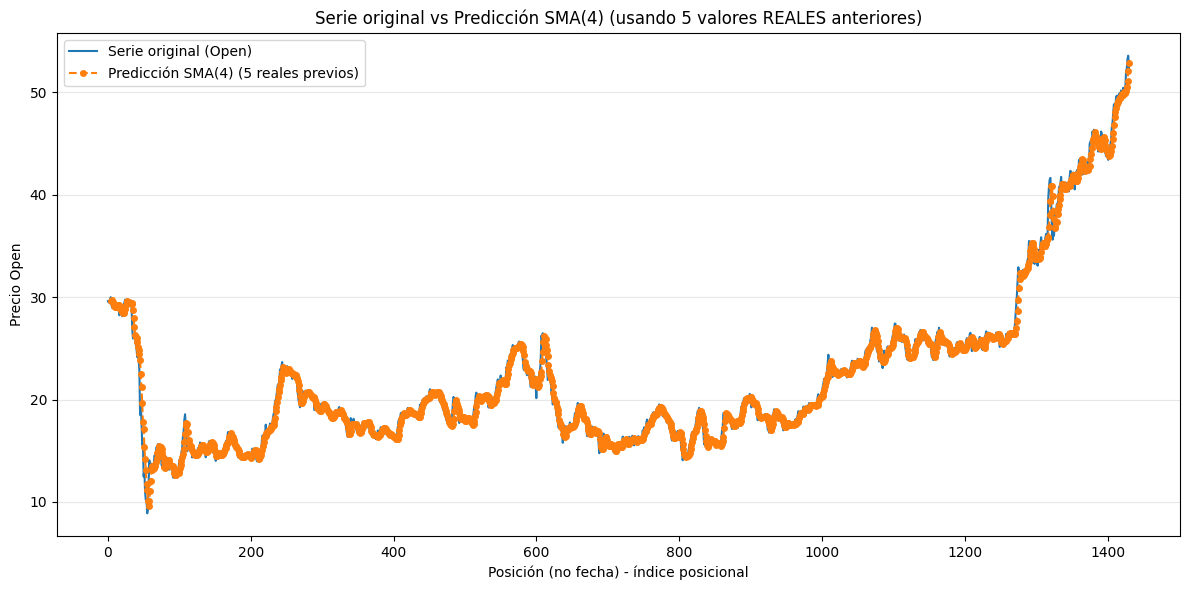

In [13]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pprint import pprint

# ---------- Descargar (o sobrescribir df_raw) ----------
TICKER = "CIB"
START = "2020-01-01"
END = "2025-09-12"

print(f"Descargando {TICKER} desde {START} hasta {END} ...")
df_raw = yf.download(TICKER, start=START, end=END)

print("\n--- DIAGNÓSTICO inicial de df_raw ---")
print("type(df_raw) =", type(df_raw))
try:
    print("repr(df_raw.head(3)):")
    print(repr(df_raw.head(3)))
except Exception as e:
    print("No se pudo mostrar head():", repr(e))
print("-" * 40)

# ---------- Función robusta para obtener/normalizar una serie 1-D ----------
def to_1d_series(obj):
    """
    Intenta convertir 'obj' a pd.Series 1-D de forma robusta.
    Devuelve (serie, info_dict) donde serie es pd.Series o None si no pudo.
    info_dict contiene datos útiles para diagnóstico.
    """
    info = {"original_type": type(obj)}
    # 1) Si ya es pd.Series
    if isinstance(obj, pd.Series):
        info["case"] = "pd.Series"
        return obj.copy(), info

    # 2) Si es pd.DataFrame
    if isinstance(obj, pd.DataFrame):
        info["case"] = "pd.DataFrame"
        info["shape"] = obj.shape
        # priorizar columna 'Open' (variantes de nombre)
        col_candidates = [c for c in obj.columns if str(c).strip().lower() == "open"]
        if col_candidates:
            s = obj[col_candidates[0]].copy()
            info["extracted_col"] = col_candidates[0]
            return s, info
        # si hay columnas numéricas, tomar la primera numérica
        num_cols = obj.select_dtypes(include=[np.number]).columns.tolist()
        if num_cols:
            s = obj[num_cols[0]].copy()
            info["extracted_col"] = num_cols[0]
            return s, info
        # si solo tiene 1 columna, devolverla
        if obj.shape[1] == 1:
            s = obj.iloc[:, 0].copy()
            info["extracted_col"] = obj.columns[0]
            return s, info
        # fallback: devolver None con diagnóstico
        info["error"] = "DataFrame con >1 columnas y ninguna identificada como numérica/'Open'"
        return None, info

    # 3) Si es dict-like
    if isinstance(obj, dict):
        info["case"] = "dict"
        # buscar clave 'Open'
        for k in obj.keys():
            if str(k).strip().lower() == "open":
                try:
                    return pd.Series(obj[k]), {**info, "extracted_key": k}
                except Exception:
                    pass
        # tomar primer value convertible a serie
        for k, v in obj.items():
            try:
                s = pd.Series(v)
                return s, {**info, "extracted_key": k}
            except Exception:
                pass
        info["error"] = "dict pero no se pudo convertir valores a Series"
        return None, info

    # 4) numpy array u other array-like
    try:
        arr = np.asarray(obj)
        info["asarray_shape"] = arr.shape
        # 1-D
        if arr.ndim == 1:
            return pd.Series(arr), {**info, "case": "ndarray_1d"}
        # 2-D con 1 columna: convertir a 1-D
        if arr.ndim == 2 and arr.shape[1] == 1:
            return pd.Series(arr.ravel()), {**info, "case": "ndarray_2d_col1"}
        # 2-D con >1 col: tomar la primer columna
        if arr.ndim == 2 and arr.shape[1] > 1:
            return pd.Series(arr[:, 0]), {**info, "case": "ndarray_2d_take_col0"}
    except Exception as e:
        info["array_conversion_error"] = repr(e)

    # 5) lista / tuple iterables
    try:
        if hasattr(obj, "__iter__") and not isinstance(obj, (str, bytes)):
            lst = list(obj)
            # si len matches an index? no queremos forzar index
            return pd.Series(lst), {**info, "case": "iterable_converted_to_series", "len": len(lst)}
    except Exception as e:
        info["iterable_error"] = repr(e)

    # 6) fallback: intentar crear Series con objeto escalar (resultado será length 1)
    try:
        s = pd.Series([obj])
        return s, {**info, "case": "scalar_wrapped"}
    except Exception as e:
        info["final_error"] = repr(e)
        return None, info

# ---------- Intentar extraer s_raw ----------
s_raw, info = to_1d_series(df_raw)
print("Intento convertir df_raw -> serie 1-D. Resultado info:")
pprint(info)
print("-" * 40)

if s_raw is None:
    raise TypeError("No se pudo extraer una serie 1-D desde df_raw. Mira el diagnóstico anterior.")

# Mostrar tipo y primeras filas de s_raw
print("type(s_raw):", type(s_raw))
try:
    print("s_raw.head(5):")
    print(s_raw.head(5))
except Exception as e:
    print("No se pudo mostrar s_raw.head():", repr(e))

# ---------- Convertir a numérico sin forzar índices incompatibles ----------
# No pasamos index al crear Series intermedia para evitar mismatches.
try:
    # crear una Series limpia (sin index problemático): usar los valores puros
    s_vals = list(s_raw)
    s_candidate = pd.Series(s_vals)
    series = pd.to_numeric(s_candidate, errors='coerce')
except Exception as e:
    print("Error al construir s_candidate desde s_raw:", repr(e))
    # como último recurso intentar forzar elemento por elemento
    cleaned = []
    for i, v in enumerate(s_raw):
        try:
            cleaned.append(float(v))
        except Exception:
            try:
                cleaned.append(float(str(v).replace(',', '.')))
            except Exception:
                cleaned.append(np.nan)
    series = pd.Series(cleaned)

n_nans = int(series.isna().sum())
print(f"Valores no numéricos detectados (coercion): {n_nans}")
if n_nans > 0:
    print("Ejemplos de índices con NaN (hasta 10):")
    print(series[series.isna()].head(10))

# Eliminar NaNs y convertir a float
series = series.dropna().astype(float).reset_index(drop=True).copy()
print("Serie final válida (longitud):", len(series))
print("-" * 40)

# ---------- Predicción usando 5 valores REALES anteriores (no recursiva) ----------
WINDOW = 4
# Aquí 'series' es la Serie 1-D numérica que ya construiste y normalizaste arriba.

# pred[i] = mean(series[i-1], ..., series[i-5])
# Usamos shift(1).rolling(window=WINDOW) para que la predicción en la posición i
# use exactamente los valores reales anteriores a i.
pred_series = series.shift(1).rolling(window=WINDOW, min_periods=WINDOW).mean()
pred_series.name = f'SMA_obs_{WINDOW}'

# Si quieres que las primeras WINDOW posiciones lleven los valores reales en lugar de NaN,
# descomenta la siguiente línea (opcional):
# pred_series.iloc[:WINDOW] = series.iloc[:WINDOW]

# Convertir a array para métricas (si tu `series` está indexada posicionalmente, ya está alineado)
pred_values = pred_series.values  # contiene NaN en las primeras WINDOW posiciones

# Métricas comparando series originales (ignorando NaNs iniciales)
def mae_arr(y_true_arr, y_pred_arr):
    y_true = np.asarray(y_true_arr, dtype=float)
    y_pred = np.asarray(y_pred_arr, dtype=float)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs(y_true[mask] - y_pred[mask]))

def rmse_arr(y_true_arr, y_pred_arr):
    y_true = np.asarray(y_true_arr, dtype=float)
    y_pred = np.asarray(y_pred_arr, dtype=float)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    if mask.sum() == 0:
        return np.nan
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask])**2))

m_mae = mae_arr(series.values, pred_values)
m_rmse = rmse_arr(series.values, pred_values)
print(f"\nSMA({WINDOW}) usando 5 REALES anteriores -> MAE: {m_mae:.6f}, RMSE: {m_rmse:.6f}")

# ---------- Gráfica (alineada por posición) ----------
plt.figure(figsize=(12,6))
plt.plot(series.values, label='Serie original (Open)', linewidth=1.5)
plt.plot(pred_values, linestyle='--', marker='o', markersize=4, label=f'Predicción SMA({WINDOW}) (5 reales previos)')
plt.title(f"Serie original vs Predicción SMA({WINDOW}) (usando 5 valores REALES anteriores)")
plt.xlabel("Posición (no fecha) - índice posicional")
plt.ylabel("Precio Open")
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



Últimos 30 puntos -> SMA(4) MAE: 0.894333, RMSE: 1.111761, MAPE: 1.818470


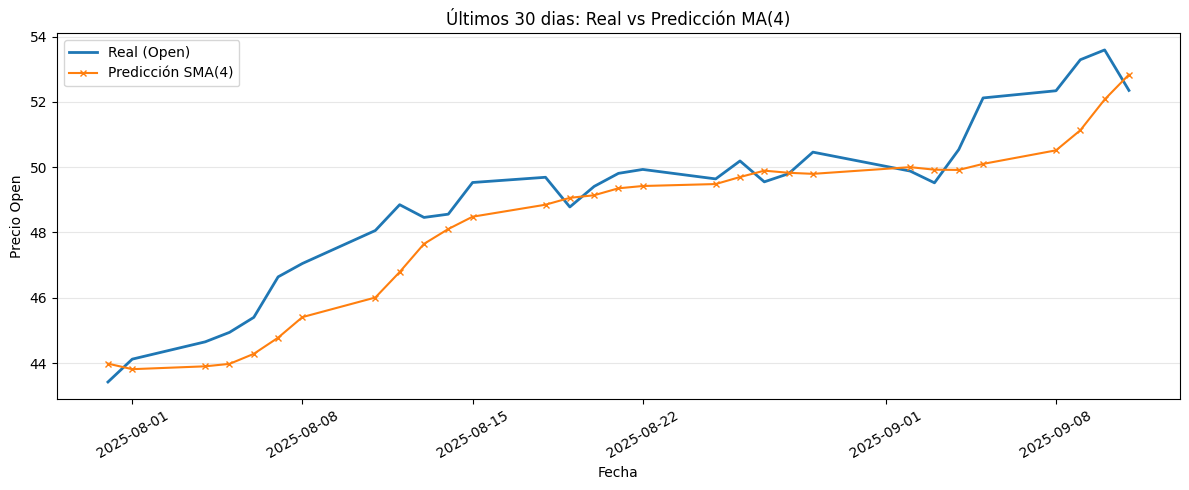

In [15]:
# # ---------- Mostrar últimos 30 puntos con fechas reales (robusto) ----------
# LAST_POINTS = 30  # últimos 30 "puntos" (observaciones). Cambia a LAST_DAYS si prefieres días calendario.

# # Intentar construir una serie indexada en fechas usando s_raw/df_raw de forma segura
# def build_series_full(df_raw, s_raw=None):
#     # preferir s_raw si ya lo extrajiste antes
#     if s_raw is not None:
#         src = s_raw
#     else:
#         try:
#             src, _ = to_1d_series(df_raw)
#         except Exception:
#             src = None

#     # si src no es Series, intentar convertirlo a una Series sin index forzado
#     if not isinstance(src, pd.Series):
#         try:
#             src = pd.Series(list(src))
#         except Exception:
#             # fallback a df_raw si es DataFrame con columna 'Open'
#             try:
#                 src = df_raw['Open']
#             except Exception:
#                 raise RuntimeError("No pude construir una Series desde s_raw ni df_raw['Open'].")

#     # si df_raw tiene índice y coincide en longitud, asignarlo (para conservar fechas)
#     try:
#         if hasattr(df_raw, 'index') and len(df_raw.index) == len(src):
#             src.index = pd.to_datetime(df_raw.index)
#     except Exception:
#         # si falla la conversión de fechas, lo ignoramos y dejamos índice posicional
#         pass

#     # convertir a numérico seguro y eliminar NaNs
#     s_num = pd.to_numeric(src, errors='coerce').dropna().astype(float)
#     return s_num

# # Construir series con fechas (o posicional si no se puede)
# try:
#     series_full = build_series_full(df_raw, s_raw if 's_raw' in globals() else None)
# except Exception as e:
#     print("Warning: no fue posible reconstruir series con fechas desde df_raw/s_raw:", e)
#     # fallback: usar la 'series' posicional que ya construiste antes (sin fechas)
#     series_full = series.copy()
#     # si 'series' no existe, lanzar error
#     if series_full is None:
#         raise RuntimeError("No existe 'series' para usar como fallback.")

# # Recalcular predicción alineada con fechas reales (pred[i] usa series_full[i-1]...i-WINDOW)
# pred_full = series_full.shift(1).rolling(window=WINDOW, min_periods=WINDOW).mean()
# pred_full.name = f'SMA_obs_{WINDOW}'

# # Seleccionar últimos LAST_POINTS puntos (observaciones)
# series_tail = series_full.tail(LAST_POINTS)
# pred_tail = pred_full.reindex(series_tail.index)  # alinear índices

# # Métricas sólo en el tramo final (ignorando NaNs)
# def mae_series(y_true, y_pred):
#     df = pd.concat([y_true, y_pred], axis=1, join='inner').dropna()
#     if df.shape[0] == 0:
#         return np.nan
#     return np.mean(np.abs(df.iloc[:,0].values - df.iloc[:,1].values))

# def rmse_series(y_true, y_pred):
#     df = pd.concat([y_true, y_pred], axis=1, join='inner').dropna()
#     if df.shape[0] == 0:
#         return np.nan
#     return np.sqrt(np.mean((df.iloc[:,0].values - df.iloc[:,1].values)**2))

# m_mae_tail = mae_series(series_tail, pred_tail)
# m_rmse_tail = rmse_series(series_tail, pred_tail)
# print(f"\nÚltimos {len(series_tail)} puntos -> SMA({WINDOW}) MAE: {m_mae_tail:.6f}, RMSE: {m_rmse_tail:.6f}")

# # Gráfica últimos puntos con fechas reales si las hay, o con índice posicional
# plt.figure(figsize=(12,5))
# # usar índice (fechas) si la serie tiene DatetimeIndex, si no usar posiciones
# if isinstance(series_tail.index, pd.DatetimeIndex):
#     x1 = series_tail.index
#     x2 = pred_tail.index
# else:
#     x1 = range(len(series_full) - len(series_tail), len(series_full))
#     x2 = x1

# plt.plot(x1, series_tail.values, label='Real (Open)', linewidth=2)
# plt.plot(x2, pred_tail.values, linestyle='--', marker='o', markersize=4, label=f'Predicción SMA({WINDOW})')
# plt.title(f"Últimos {len(series_tail)} puntos: Real vs Predicción SMA({WINDOW})")
# plt.xlabel("Fecha" if isinstance(series_tail.index, pd.DatetimeIndex) else "Posición (index posicional)")
# plt.ylabel("Precio Open")
# plt.xticks(rotation=30)
# plt.grid(axis='y', alpha=0.3)
# plt.legend()
# plt.tight_layout()
# plt.show()



# ---------- Mostrar últimos 30 puntos con fechas reales (robusto) ----------
LAST_POINTS = 30  # últimos 30 "puntos" (observaciones). Cambia a LAST_DAYS si prefieres días calendario.

# Intentar construir una serie indexada en fechas usando s_raw/df_raw de forma segura
def build_series_full(df_raw, s_raw=None):
    # preferir s_raw si ya lo extrajiste antes
    if s_raw is not None:
        src = s_raw
    else:
        try:
            src, _ = to_1d_series(df_raw)
        except Exception:
            src = None

    # si src no es Series, intentar convertirlo a una Series sin index forzado
    if not isinstance(src, pd.Series):
        try:
            src = pd.Series(list(src))
        except Exception:
            # fallback a df_raw si es DataFrame con columna 'Open'
            try:
                src = df_raw['Open']
            except Exception:
                raise RuntimeError("No pude construir una Series desde s_raw ni df_raw['Open'].")

    # si df_raw tiene índice y coincide en longitud, asignarlo (para conservar fechas)
    try:
        if hasattr(df_raw, 'index') and len(df_raw.index) == len(src):
            src.index = pd.to_datetime(df_raw.index)
    except Exception:
        pass

    # convertir a numérico seguro y eliminar NaNs
    s_num = pd.to_numeric(src, errors='coerce').dropna().astype(float)
    return s_num

# Construir series con fechas (o posicional si no se puede)
try:
    series_full = build_series_full(df_raw, s_raw if 's_raw' in globals() else None)
except Exception as e:
    print("Warning: no fue posible reconstruir series con fechas desde df_raw/s_raw:", e)
    series_full = series.copy()
    if series_full is None:
        raise RuntimeError("No existe 'series' para usar como fallback.")

# Recalcular predicción alineada con fechas reales
pred_full = series_full.shift(1).rolling(window=WINDOW, min_periods=WINDOW).mean()
pred_full.name = f'SMA_obs_{WINDOW}'

# Seleccionar últimos LAST_POINTS puntos
series_tail = series_full.tail(LAST_POINTS)
pred_tail = pred_full.reindex(series_tail.index)

# Métricas
def mae_series(y_true, y_pred):
    df = pd.concat([y_true, y_pred], axis=1, join='inner').dropna()
    if df.shape[0] == 0:
        return np.nan
    return np.mean(np.abs(df.iloc[:,0].values - df.iloc[:,1].values))

def rmse_series(y_true, y_pred):
    df = pd.concat([y_true, y_pred], axis=1, join='inner').dropna()
    if df.shape[0] == 0:
        return np.nan
    return np.sqrt(np.mean((df.iloc[:,0].values - df.iloc[:,1].values)**2))

# --------- NUEVA MÉTRICA: MAPE ---------
def mape_series(y_true, y_pred):
    df = pd.concat([y_true, y_pred], axis=1, join='inner').dropna()
    if df.shape[0] == 0:
        return np.nan
    y_true_vals = df.iloc[:,0].values
    y_pred_vals = df.iloc[:,1].values
    return np.mean(np.abs((y_true_vals - y_pred_vals) / y_true_vals)) * 100
# ----------------------------------------

m_mae_tail = mae_series(series_tail, pred_tail)
m_rmse_tail = rmse_series(series_tail, pred_tail)
m_mape_tail = mape_series(series_tail, pred_tail)   # <-- agregado

print(f"\nÚltimos {len(series_tail)} puntos -> SMA({WINDOW}) MAE: {m_mae_tail:.6f}, RMSE: {m_rmse_tail:.6f}, MAPE: {m_mape_tail:.6f}")

# Gráfica
plt.figure(figsize=(12,5))
if isinstance(series_tail.index, pd.DatetimeIndex):
    x1 = series_tail.index
    x2 = pred_tail.index
else:
    x1 = range(len(series_full) - len(series_tail), len(series_full))
    x2 = x1

plt.plot(x1, series_tail.values, label='Real (Open)', linewidth=2)
plt.plot(x2, pred_tail.values, marker='x', markersize=4, label=f'Predicción SMA({WINDOW})')
plt.title(f"Últimos {len(series_tail)} dias: Real vs Predicción MA({WINDOW})")
plt.xlabel("Fecha" if isinstance(series_tail.index, pd.DatetimeIndex) else "Posición (index posicional)")
plt.ylabel("Precio Open")
plt.xticks(rotation=30)
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

